In [1]:
import torch.nn as nn
from networks import *
from train_utils import *
import matplotlib.pyplot as plt

n_epochs = 42
batch_size = 128
batch_size_test = 1028
device = "cpu"

In [2]:
def trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def plot_accuracy(model, stats):
    fig, ax = plt.subplots(1,1, figsize=(7,5))
    ax.plot(1-stats["train_accuracy"], label="training")
    ax.plot(1-stats["test_accuracy"], label="test")
    ax.set_xlabel("epoch")
    ax.set_ylabel("error")
    fig.legend(loc="center right")
    best_epoch = np.argmax(stats["test_accuracy"])
    print("The minimum test error is {:1.2}% in epoch {}".format((1-stats["test_accuracy"][best_epoch])*100, best_epoch))
    print("The model has {:1.2} Million Parameters".format(trainable_params(model)/1e6))

In [3]:
In total I run 6 different experiments on the MNIST dataset. 

SyntaxError: invalid syntax (<ipython-input-3-94d1ca0b23da>, line 1)

# Experiment 1 - Baseline Resnet
The first experiment reproduces the baseline given by "ResNet" in Table 1 of [1]. After downsampling the input six residual layers are applied. Each block consists of two Convolution, ReLU and Normalisation layers. 

In [ ]:
resnet_6 = nn.Sequential(*get_downsampling_layers(), *get_residual_blocks(6), *get_final_layers())
trained_resnet_6 = train_model_cached(resnet_6, file_path="cached_models/resnet6.pth", batch_size=batch_size, test_batch_size=batch_size_test, epochs=n_epochs, verbosity=2, device=device)

In [ ]:
plot_accuracy(*trained_resnet_6)

The best test error of 0.42% almoust perfectly replicates the error of 0.41% reported in [1] (Table 1 "ResNet"). However the architecture I am using has 70k less parameters then the number of parameters reported in [1]. 

# Experiment 2 - Simpler ResNet
In addition to the previous model, I also try a residual neural network with only a single residual block instead of six. 

In [ ]:
simple_resnet = nn.Sequential(*get_downsampling_layers(), *get_residual_blocks(1), *get_final_layers())
simple_resnet_trained = train_model_cached(simple_resnet, file_path="cached_models/simple_resnet1.pth", batch_size=batch_size, test_batch_size=batch_size_test, epochs=n_epochs, verbosity=2, device=device)

In [ ]:
plot_accuracy(*simple_resnet_trained)

This model has only 0.16 Million trainable parameters, which is even fewer then the ODE-Network reported in the paper. 

## Experiment 3.1 - Default ODE Network (Group-Norm)
This experminet replicates the entry for "ODE-Net" in Table 1 of [1].  


In [ ]:
standard_ode_group = nn.Sequential(*get_downsampling_layers(), ODEBlock(ConvolutionalDynamicsFunction(64, time_dependent=True, norm_type="group"), device=device), *get_final_layers())
standard_ode_group_trained = train_model_cached(standard_ode_group, file_path="cached_models/ode_group.pth", batch_size=batch_size, test_batch_size=batch_size_test, epochs=n_epochs, verbosity=2, device=device)

In [ ]:
plot_accuracy(*standard_ode_group_trained)

## Experiment 3.2 - Default ODE Network (Batch Norm)

In [ ]:
standard_ode_batch = nn.Sequential(*get_downsampling_layers(), ODEBlock(ConvolutionalDynamicsFunction(64, time_dependent=True, norm_type="batch"), device=device), *get_final_layers())
standard_ode_batch_trained = train_model_cached(standard_ode_batch, file_path="cached_models/ode_batch.pth", batch_size=batch_size, test_batch_size=batch_size_test, epochs=n_epochs, verbosity=2, device=device)

In [ ]:
plot_accuracy(*standard_ode_batch_trained)

## Experiment 4.1 - ODE-Net without time dependence 

In [ ]:
no_time_ode_group = nn.Sequential(*get_downsampling_layers(), ODEBlock(ConvolutionalDynamicsFunction(64, time_dependent=False, norm_type="group"), device=device), *get_final_layers())
no_time_ode_group_trained = train_model_cached(no_time_ode_group, file_path="cached_models/no_time_ode_group.pth", batch_size=batch_size, test_batch_size=batch_size_test, epochs=n_epochs, verbosity=2, device=device)

In [ ]:
plot_accuracy(*no_time_ode_group_trained)

## Experiment 4.2 -  ODE-Net without time dependence (Batch-Norm)

In [ ]:
no_time_ode_batch = nn.Sequential(*get_downsampling_layers(), ODEBlock(ConvolutionalDynamicsFunction(64, time_dependent=False, norm_type="batch"), device=device), *get_final_layers())
no_time_ode_batch_metric = ODEMetric()
no_time_ode_batch_trained = train_model(no_time_ode_batch, batch_size=batch_size,
                                        test_batch_size=batch_size_test,
                                        epochs=n_epochs,
                                        verbosity=2, device=device,
                                        specialised_metric=no_time_ode_batch_metric)

# Visualisations
Finally I add two visualisations that illustrate the difference between the discrete feature transformation in the Res-Net case and the  continuous feature transform in the ODE-Net case

In [43]:
## Helper Functions
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML
rc('animation', html='html5')

def reshape_time_course(timecourse):
    """reshapes the feature maps to a 2D picture"""
    n_times, n_channel, x_dim, y_dim = timecourse.shape
    assert(x_dim == y_dim)
    grid_size = int(np.sqrt(n_channel))
    
    outputsize = grid_size*x_dim+(grid_size-1)
    
    output = np.ones((n_times, outputsize, outputsize))*np.min(timecourse)
    for channel_id in range(n_channel):
        grid_y = channel_id // grid_size
        grid_x = channel_id % grid_size
        
        start_y = grid_y * x_dim + grid_y
        start_x = grid_x * x_dim + grid_x
        
        output[:, start_y:(start_y+x_dim), start_x:(start_x+x_dim)] = timecourse[:, channel_id, :, :]
    return output

def animate_transformation(all_channel_timecourse, video_length, filename):
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    plt.axis("off")
    
    data = reshape_time_course(all_channel_timecourse)
    
    ims = list()
    for t in range(len(data)):
        im = ax.imshow(data[t], animated=True)
        ims.append([im])
        
    n_frames = len(data)
    interval = video_length*1000 / n_frames
    fps = n_frames/video_length
        
    ani = animation.ArtistAnimation(fig, ims, interval=interval, blit=True, repeat_delay=22000)
    
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=fps, metadata=dict(artist='Me'), bitrate=1800)
    ani.save(filename, writer)
    
    vid = HTML(ani.to_html5_video())
    return vid


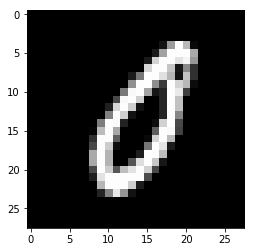

In [44]:
train_loader, test_loader = get_data_loaders(batch_size=10)
for batch in test_loader:
    imgs, label = batch
    break
img = imgs[:1]
label = label[:1]
_ = plt.imshow(img.detach().numpy()[0, 0, :, :], cmap="gray")


In [45]:
res_blocks = get_residual_blocks(6, cache_last_activation=True)
resnet_6_demo = nn.Sequential(*get_downsampling_layers(), *res_blocks, *get_final_layers())
_ = train_model_cached(resnet_6_demo, file_path="cached_models/resnet6.pth")
_= resnet_6_demo.eval()

Experiment cached_models/resnet6.pth
Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
  (6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (7): ResidualBlock(
    (norm_layer1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_layer1): ReLU(inplace)
    (conv_layer1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
    (norm_layer2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_layer2): ReLU(inplace)
    (conv_layer2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
  )
  (8): ResidualBlock(
    (norm_layer1): BatchNorm2d(64, eps=1e-05, momentum=

In [46]:
out = resnet_6_demo(img).detach().numpy()
prediction = np.argmax(out, axis=-1)
print("Prediction: {} | Label: {}".format(prediction[0], label[0]))

Prediction: 0 | Label: 0


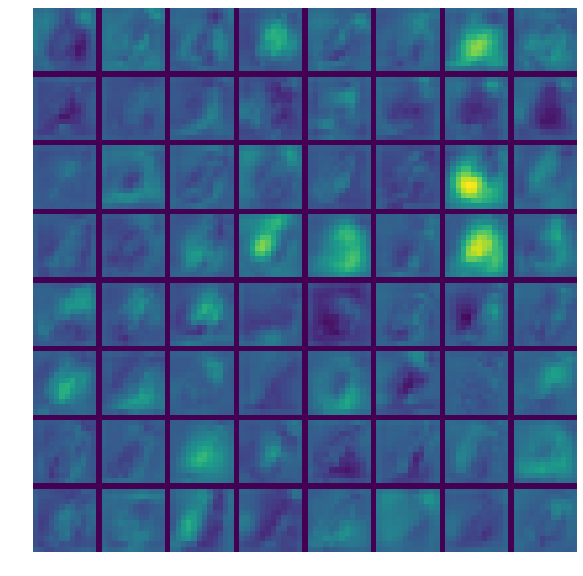

In [47]:
res_hidden_activation_series = np.concatenate([np.expand_dims(l.last_activation.detach().numpy()[0],0) for l in res_blocks], axis=0)
animate_transformation(res_hidden_activation_series, 6, "test.mp4")

# Sources

[1] Neural Ordinary Differential Equations; Ricky T. Q. Chen, Yulia Rubanova, Jesse Bettencourt, David Duvenaud (2019)
 